# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tools.eval_measures import rmse
from scipy.fftpack import fft
from scipy import signal

# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [3]:
sensor.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [4]:
sensor.isnull().sum()

attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [5]:
sensor.shape

(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [6]:
time_range  = pd.date_range(start='1/1/2018 00:00:00', 
                            end='1/1/2018 00:29:10', 
                            periods=len(sensor))
time_index  = pd.DatetimeIndex(time_range, freq='infer')

Assign the time series index to the dataframe's index.

In [7]:
sensor.index=time_index
sensor.head(3)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function.

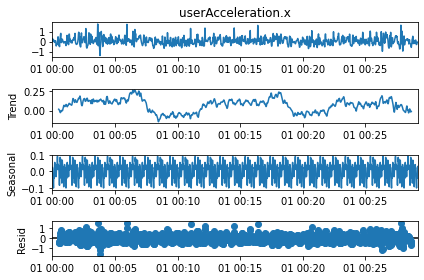

In [8]:
import statsmodels.api as sm

data = sensor["userAcceleration.x"]
res = sm.tsa.seasonal_decompose(data, period=60)
res.plot()
print("")

Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

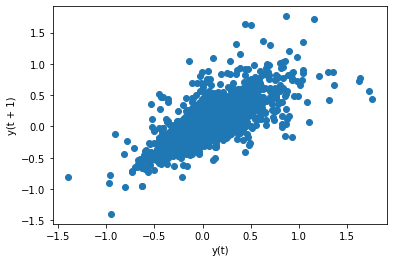

In [9]:
pd.plotting.lag_plot(sensor['userAcceleration.x'])

Create a lag plot for `rotationRate.x`

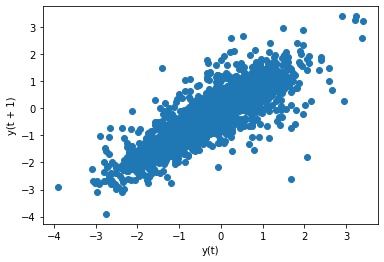

In [10]:
pd.plotting.lag_plot(sensor['rotationRate.x'])

What are your conclusions from both visualizations?

In [11]:
#It plots the observation at time t on the x-axis and 
#the lag1 observation (t-1) on the y-axis.

In [12]:
#If the points cluster along a diagonal line from the bottom-left to the 
#top-right of the plot, it suggests a positive correlation relationship.

#A ball in the middle or a spread across the plot suggests a weak or no relationship.

#userAcceleration.x has a stronger relationship than rotationRate.x

The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

- In a stationary time series, statistical properties such as mean and variance are constant over time.
- In a non-stationary series, these properties are dependent on time.

In [13]:
#H0: There is the presence of a unit root (Stationarity doesn't exist)
#Threshold: 0.05
adfTest_acc = adfuller(sensor['userAcceleration.x'], autolag='AIC')
print('pValue userAcceleration.x: ', adfTest_acc[1])

adfTest_rot = adfuller(sensor['rotationRate.x'], autolag='AIC')
print('pValue rotationRate.x: ', adfTest_rot[1])

pValue userAcceleration.x:  2.823439483037483e-30
pValue rotationRate.x:  6.320230335912249e-06


What are your conclusions from this test?

In [14]:
#pValue userAcceleration.x < 0.05 -> Se rechaza H0
#pValue rotationRate.x < 0.05 -> Se rechaza H0
#Conclussion: Stationarity exists

Finally, we'll create an ARMA model for `userAcceleration.x`. Load the `ARMA` function from `statsmodels`. The order of the model is (2, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [15]:
print(len(sensor['userAcceleration.x']))

1751


In [16]:
train = sensor['userAcceleration.x'][:1751-10]
test  = sensor['userAcceleration.x'][1751-10:]
model = ARMA(train, order=(2,1))
arma_results = model.fit()
y_pred = arma_results.predict(start=len(train),end=len(train)+len(test)-1, dynamic=False)

In [17]:
results = pd.DataFrame({
    "real":test,
    "pred":y_pred,
    "diff":y_pred-test
})

display(results)

,real,pred,diff
2018-01-01 00:29:01,0.149749,0.173149,0.023400
2018-01-01 00:29:02,0.038461,0.142896,0.104435
2018-01-01 00:29:03,-0.169175,0.100522,0.269697
2018-01-01 00:29:04,-0.300361,0.070106,0.370467
2018-01-01 00:29:05,-0.270174,0.056099,0.326273
2018-01-01 00:29:06,-0.268367,0.053778,0.322145
2018-01-01 00:29:07,-0.102444,0.056790,0.159234
2018-01-01 00:29:08,-0.085590,0.060646,0.146236
2018-01-01 00:29:09,-0.048105,0.063316,0.111421
2018-01-01 00:29:10,-0.065011,0.064493,0.129504


To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [18]:
print("RMSE = ", rmse(results.real, results.pred, axis=0))

RMSE =  0.2252986433587337


## > Limpiando datos con filtro paso bajo

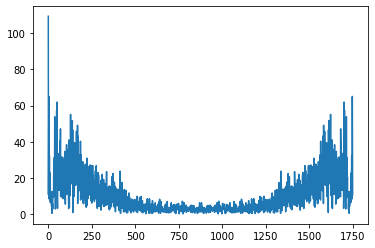

In [19]:
fft_y = np.abs(fft(sensor['userAcceleration.x'].values))
plt.plot(fft_y)

In [20]:
Fc=200
Fm=1751
b, a = signal.butter(3, Fc/Fm)
Y = sensor['userAcceleration.x']
Y_clean = signal.filtfilt(b, a, Y)

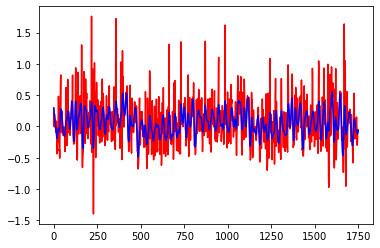

In [21]:
plt.plot(Y.values, '-', color='red')
plt.plot(Y_clean, '-', color='blue')

## > Probando a correr de nuevo el modelo 

In [22]:
train = Y_clean[:1751-10]
test  = Y_clean[1751-10:]

In [23]:
#AR order 2 -> Number of lag observations included in the model (coefs)
#MA order 0 -> Size of the moving average window
model = ARMA(train, order=(2,0))
arma_results = model.fit()
y_pred = arma_results.predict(start=len(train),end=len(train)+len(test)-1, dynamic=False)

In [24]:
results = pd.DataFrame({
    "real":test,
    "pred":y_pred,
    "diff":y_pred-test
})

display(results)

,real,pred,diff
0,-0.079346,-0.071361,0.007985
1,-0.090804,-0.067323,0.023481
2,-0.102650,-0.057951,0.044699
3,-0.112747,-0.043741,0.069006
4,-0.118969,-0.025381,0.093587
5,-0.119777,-0.003714,0.116063
6,-0.114556,0.020298,0.134854
7,-0.103652,0.045616,0.149268
8,-0.088194,0.071168,0.159362
9,-0.069828,0.095897,0.165725


In [25]:
print("RMSE = ", rmse(results.real, results.pred, axis=0))

RMSE =  0.1108745732929472


In [26]:
#El error ha bajado bastante